# Baysian Optimisation to find good Hyperparameters
To  find a good set of hyperparameters for the XGB model, a Baysian optimisation based on a time based train test split is used. This is done because the model will try to run inference based on predicted weather data. So a time based train test split where the entire data set minus one week is the train set and the test set is the final week. This ensures that we optimize the model for the correct purpose.

In [3]:
# Library Imports
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import optuna


# Data import
df = pd.read_csv("../data/finalData2.csv")
df['time'] = pd.to_datetime(df['time'])
df.drop(["Unnamed: 0",'oerlikon'],axis = 1  ,inplace=True)
stop = df['time'].iloc[-1]
start = stop - pd.Timedelta(weeks=1)
timemask = (df['time'] >= start) & (df['time'] <= stop)
time = df['time']
df.drop('time', axis = 1, inplace = True)
X_train = df[timemask == 0].drop('city', axis = 1)
y_train = df[timemask == 0]['city']
X_test = df[timemask].drop('city', axis = 1)
y_test = df[timemask]['city']

c:\Users\Etienne\anaconda3\envs\opti-swim-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Baseline
For compairison later on we use a xgb model with default para meters

Text(0.5, 1.0, 'MSE 385.81975861542185')

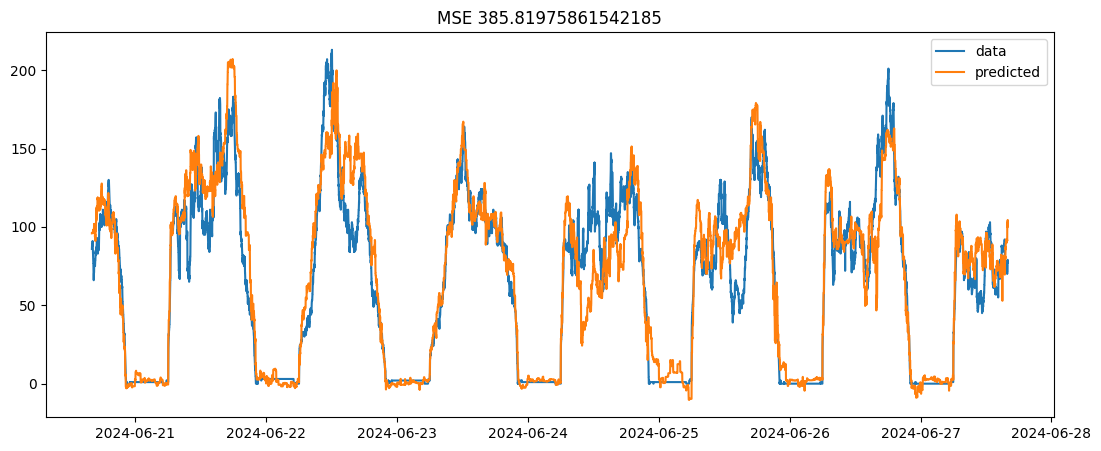

In [4]:
# Train
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

# Inference
y_pred = reg.predict(X_test)


# Plot
test_time = time[timemask]
plt.figure(figsize=(13,5))
plt.plot(test_time, y_test, marker = " ", label= "data")
plt.plot(test_time, y_pred, marker = " ", label= "predicted")
plt.legend()
plt.title(f"MSE {mse(y_pred, y_test)}")



# Optimizing
Code is based on [this](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py). This is very performance intensive. This is why i executed it on my local HPC cluster. 3.5 h @ 21 cores.

In [5]:

def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "n_estimators": trial.suggest_int("n_estimators",5,500),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # bst = xgb.train(param, X_train)
    reg = xgb.XGBRegressor(**param)
    reg.fit(X_train, y_train)
    y_pred =  reg.predict(X_test)
    return mse(y_pred, y_test)





# Eval of the optimisation

In [9]:
study = optuna.load_study(study_name="XGB-RUN-3-euler", storage="sqlite:///optuna.db")
print(f'Results:  MSE: {study.best_value} \n With the params:')
study.best_params

Results:  MSE: 227.59564480571188 
 With the params:


{'booster': 'dart',
 'lambda': 1.0587460946950177e-07,
 'alpha': 2.5171950690334148e-05,
 'subsample': 0.4413216070091265,
 'colsample_bytree': 0.7119317748088,
 'n_estimators': 384,
 'max_depth': 9,
 'min_child_weight': 7,
 'eta': 0.04185026852037536,
 'gamma': 2.0698758731425786e-08,
 'grow_policy': 'lossguide',
 'sample_type': 'weighted',
 'normalize_type': 'forest',
 'rate_drop': 0.0037670294066052086,
 'skip_drop': 0.00048216391587428323}

In [11]:
# Save params
f = open("BestParams.txt", "w")
f.write(str(study.best_params))
f.close()

In [9]:
study.best_value

233.6020807900681

# Compare to baseline

Text(0.5, 1.0, 'MSE 385.81975861542185')

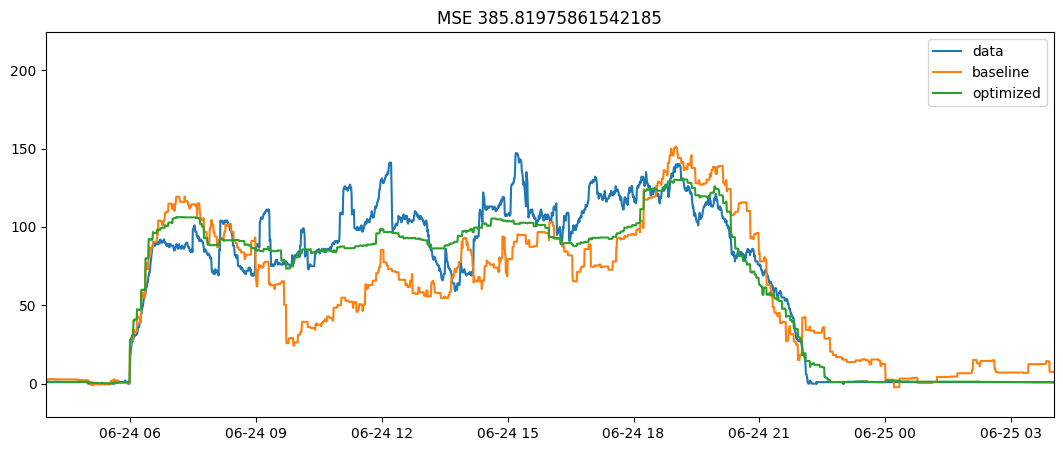

In [25]:
# Train
reg = xgb.XGBRegressor(**study.best_params)
reg.fit(X_train, y_train)

# Inference
y_pred_opt= reg.predict(X_test)

test_time = time[timemask].reset_index().dropna()['time']
plt.figure(figsize=(13,5))
plt.plot(test_time, y_test, marker = " ", label= "data")
plt.plot(test_time, y_pred, marker = " ", label= "baseline")
plt.plot(test_time, y_pred_opt, marker = " ", label= "optimized")
plt.xlim(test_time[0] + pd.Timedelta(days = 3.5),test_time[0] + pd.Timedelta(days = 4.5))
plt.legend()
plt.title(f"MSE {mse(y_pred, y_test)}")


In [21]:
test_time

,index,time
0,392816,2024-06-20 16:00:24
1,392817,2024-06-20 16:00:54
2,392818,2024-06-20 16:01:24
3,392819,2024-06-20 16:01:54
4,392820,2024-06-20 16:02:25
...,...,...
19980,412796,2024-06-27 15:57:34
19981,412797,2024-06-27 15:58:05
19982,412798,2024-06-27 15:58:35
19983,412799,2024-06-27 15:59:06
